# 摘要

在本notebook中，*时空图神经网络 (STGNN)* 在 *csi300* 数据集上进行训练和评估。
首先，对数据进行任务预处理并分析其分布。接下来，构建模型并在处理后的数据上进行训练。最后，在训练过程中未使用的数据子集上对模型进行测试。
有关所使用函数的更详细信息，请查看 `src` 文件夹内 Python 文件中的相应文档字符串。

In [112]:
import sys
import os
import numpy as np

# 在项目的根文件夹中设置主路径
sys.path.append(os.path.join('..'))

In [113]:
# 自动重新加载的设置
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
from src.utils.seed import set_random_seed

# 设置用于确定性操作的随机种子
SEED = 42
set_random_seed(SEED)

In [115]:
import torch

# 设置用于训练和查询模型的设备
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The selected device is: "{DEVICE}"')

The selected device is: "cpu"


# 1 数据准备
***csi300*** 数据集为300只沪深300成分股15分钟K线数据。

数据集获取或更改可在`DataStrac.ipynb`实现，这里使用的实例是
从 $2025/3/31 9:45:00$ 到 $2025/5/16 15:00$ 这一个多月的数据。

数据点总数为 $148800$ 个。

## 1.1 数据集提取与准备
首先，提取展示不同时间戳下股票收盘价的数据集，以及包含不同股票间空间相关性的邻接矩阵。

接下来，对时间信息进行编码，并将其整合到包含节点值的数据集中，以确保其格式适合模型运算。


In [116]:
# 设置数据目录。
RAW_DATA_DIR = os.path.join('..', 'data', 'csi300', 'raw')
PROCESSED_DATA_DIR = os.path.join('..', 'data', 'csi300', 'processed')

得到的数据具有以下结构：
* 节点值数据集的形式为 $\mathbb{R}^{T \times N \times F}$。
* 邻接矩阵的形式为 $\mathbb{R}^{N \times N}$。

其中，$T$ 是时间戳的数量， $N$ 是节点（股票）的数量， $F$ 是特征的数量。

在本实验中，*csi300*数据集使用的特征顺序如下：
* 股票在特定时间戳观察到的收盘价。
* 观察到的收盘价对应的当天的编码小时数。
* 观察到的收盘价对应的小时内的编码分钟数。

In [117]:
from src.data.data_extraction import get_node_values_dataframe

# 获取包含不同时间戳下节点值的数据帧
node_values_df = get_node_values_dataframe(
    os.path.join(RAW_DATA_DIR, 'csi300.h5'), turn_in_kmph=False)

In [118]:
from src.data.data_processing import get_node_values_numpy_matrix

# 设置时间聚合和编码的方法
TIME_AGGREGATIONS = [ 'time_of_day', 'day_of_week' ]

# 获取对股票收盘价以及关于一天中的小时和小时内分钟的时间信息进行编码的NumPy矩阵
# 关于一天中的小时和小时内分钟的时间信息
node_values, node_times = get_node_values_numpy_matrix(
    node_values_df, time_aggregations=TIME_AGGREGATIONS)

In [119]:
print('Shape of the node value matrix:', node_values.shape)

Shape of the node value matrix: (496, 300, 9)


最后，数据被划分为训练集、验证集和测试集，为满足问题需求，这些数据集将在其他部分进行组织。

邻接矩阵是通过阈值化高斯核，利用股票之间的成对距离构建。

$$
W_{ij} = \begin{cases}
\exp \left ( - \frac{\text{dist}(v_i - v_j)^2}{\sigma^2} \right ) & \text{若} \ \leq k \\
0 & \text{否则}\\
\end{cases}
$$

其中 $W_{ij}$ 表示股票$v_i$ 与股票 $v_j$ 之间的边权重，$\text{dist}(v_i - v_j)$ 表示从股票 $v_i$ 到股票 $v_j$ 的距离。$\sigma$ 是距离的标准差，$k$是阈值。


In [120]:
from src.data.data_extraction import get_adjacency_matrix

# 获取邻接矩阵
adj_matrix_structure = get_adjacency_matrix(
    os.path.join(RAW_DATA_DIR, 'adj_mx_stocks_gaussian_kernel.pkl'))

adj_matrix_from_func = adj_matrix_structure

print("adj_matrix_from_func 的类型:", type(adj_matrix_from_func))
print("adj_matrix_from_func 的内容 (前几行):")
if isinstance(adj_matrix_from_func, np.ndarray):
    print(adj_matrix_from_func[:3, :3]) 
    print("adj_matrix_from_func 的形状:", adj_matrix_from_func.shape)
else:
    print(adj_matrix_from_func)



adj_matrix_from_func 的类型: <class 'list'>
adj_matrix_from_func 的内容 (前几行):
[['1', '100', '1289', '157', '166', '1965', '1979', '2', '2001', '2007', '2027', '2028', '2049', '2050', '2074', '2129', '2142', '2179', '2180', '2230', '2236', '2241', '2252', '2271', '2304', '2311', '2352', '2371', '2415', '2422', '2459', '2460', '2463', '2466', '2475', '2493', '2555', '2594', '2601', '2648', '2709', '2714', '2736', '2812', '2916', '2920', '2938', '300014', '300015', '300033', '300059', '300122', '300124', '300274', '300308', '300316', '300347', '300394', '300408', '300413', '300418', '300433', '300442', '300450', '300498', '300502', '300628', '300661', '300750', '300759', '300760', '300782', '300832', '300896', '300979', '300999', '301', '301269', '333', '338', '3816', '408', '425', '538', '568', '596', '600000', '600009', '600010', '600011', '600015', '600016', '600018', '600019', '600023', '600025', '600026', '600027', '600028', '600029', '600030', '600031', '600036', '600039', '600048', '600

In [121]:
# 获取邻接矩阵的表头和矩阵本身。
header, _, adj_matrix = adj_matrix_structure

In [122]:
# 断言邻接矩阵的表头节点顺序与节点值数据帧的列节点表头顺序一致。
assert all(header == node_values_df.columns.values), \
'The columns of the node values dataframe are not ordered in the ' +\
'same fashion as the adjacency matrix header.'

In [123]:
print('Shape of the adjacency matrix:', adj_matrix.shape)

Shape of the adjacency matrix: (300, 300)


数据集按照0.7、0.1和0.2的比例分别划分为*训练集*、*验证集*和*测试集*。

In [124]:
from src.data.dataset_builder import train_test_val_split

# 将数据集划分为训练集、验证集和测试集。
(train_dataset, val_dataset, test_dataset,
 train_times, val_times, test_times) = train_test_val_split(
    node_values, node_times, test_size=.2, val_size=.1)

## 1.2 数据预处理
在本节中，对数据进行预处理，以便更好地适应模型结构。

本节将解释数据标准化过程，并通过使用滑动窗口，将数据集划分为自监督回归任务的输入数据和真实数据。 

首先，创建一个“缩放器”对数据应用“标准缩放”。此过程能使模型表现更佳。

给定一个实例$x$，假设$x$的一个特征表示为$x_f$，其经过处理的版本$x'_f$可通过以下公式得到：
$$ \forall \ f \ \text{of} \ x, \ x'_f = \frac{x_f - \mu_f}{\sigma_f}$$
其中$\mu_f$是特征$f$的均值，$\sigma_f$是其标准差。

均值和标准差是根据用于训练模型的数据进行估计的。

In [125]:
from src.data.data_processing import Scaler

# 使用训练数据集的值拟合标准缩放器。
scaler = Scaler(torch.tensor(train_dataset, dtype=torch.float32),
                has_day_of_week=True)

In [126]:
import pickle

with open(os.path.join(PROCESSED_DATA_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

In [127]:
print('The scaler mean values:', scaler.mean.cpu().numpy())
print('The scaler standard deviation values:', scaler.std.cpu().numpy())

The scaler mean values: [46.309868    0.51492923  0.          0.          0.          0.
  0.          0.          0.        ]
The scaler standard deviation values: [1.0961733e+02 7.6992303e-02 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00]


观察了原始训练数据的统计信息。

我们可以看到，在原始数据中，没有任何特征的均值为0且标准差为1，因此数据未进行归一化处理。通过观察特征的分布情况，可以清楚地看到 `close` 特征（收盘价）呈现出左偏态正态分布。这是可以预料到的，因为高速公路上的车速往往更接近较高的值，而不是较低的速度。在0处的高峰是由于数据集中存在大量缺失值。

对时间进行编码的特征呈现出均匀分布。 

In [128]:
from src.data.data_analysis import get_node_values_statistics_dataframe

statistics_df = get_node_values_statistics_dataframe(
    train_dataset, feature_names=['Closing', 'time of the day',
                                  'day of the week'],
    has_day_of_the_week=True)

In [129]:
statistics_df.describe()

,Closing,time of the day,day of the week
count,106800.000000,106800.000000,106800.000000
mean,46.309869,0.514929,1.764045
std,109.617335,0.076992,1.340998
min,1.620000,0.406532,0.000000
25%,9.390000,0.437804,1.000000
50%,19.870000,0.479500,2.000000
75%,43.490000,0.583739,3.000000
max,1582.520000,0.625434,4.000000


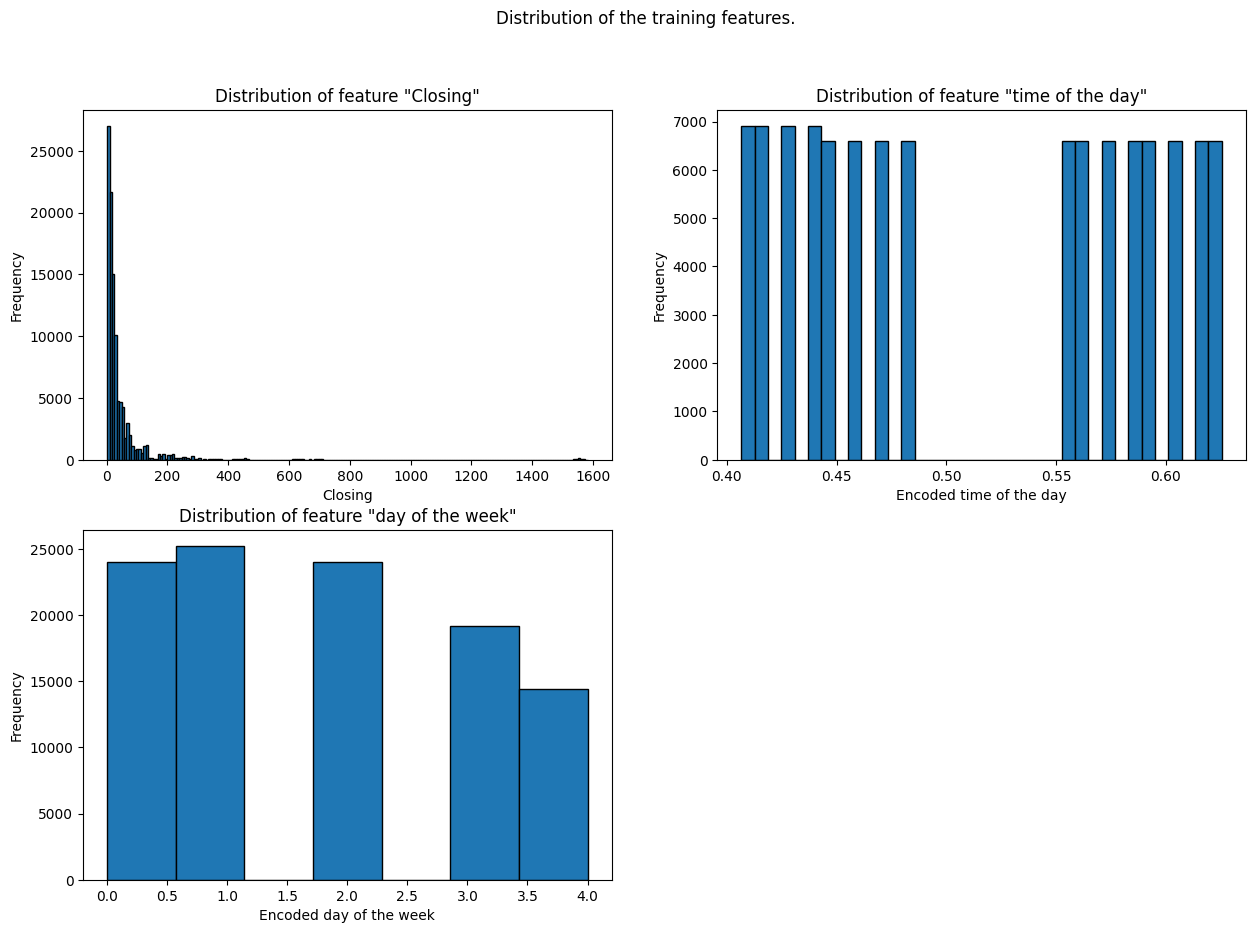

In [130]:
from src.data.data_analysis import plot_features_distribution

plot_features_distribution(
    statistics_df, bins=[200, 24 + 60 // 5, 7], 
    x_labels=['Closing', 'Encoded time of the day',
              'Encoded day of the week'],
    title='Distribution of the training features.')

In [131]:
# 通过标准缩放对训练数据集进行缩放。
scaled_train_dataset = scaler.scale(
    torch.tensor(train_dataset, dtype=torch.float32))

观察了缩放后训练数据的统计信息。

尽管我们可以观察到每个变量的均值为0，标准差为1，因此已被归一化，但这些分布与未缩放数据集里的分布相同。


In [132]:
from src.data.data_analysis import get_node_values_statistics_dataframe

statistics_df = get_node_values_statistics_dataframe(
    scaled_train_dataset, feature_names=['Closing', 'time of the day',
                                         'day of the week'],
    has_day_of_the_week=True)

In [133]:
statistics_df.describe()

,Closing,time of the day,day of the week
count,1.068000e+05,1.068000e+05,106800.000000
mean,9.136643e-09,-2.472923e-07,1.764045
std,1.000000e+00,1.000000e+00,1.340998
min,-4.076898e-01,-1.407893e+00,0.000000
25%,-3.368069e-01,-1.001726e+00,1.000000
50%,-2.412015e-01,-4.601706e-01,2.000000
75%,-2.572464e-02,8.937185e-01,3.000000
max,1.401430e+01,1.435275e+00,4.000000


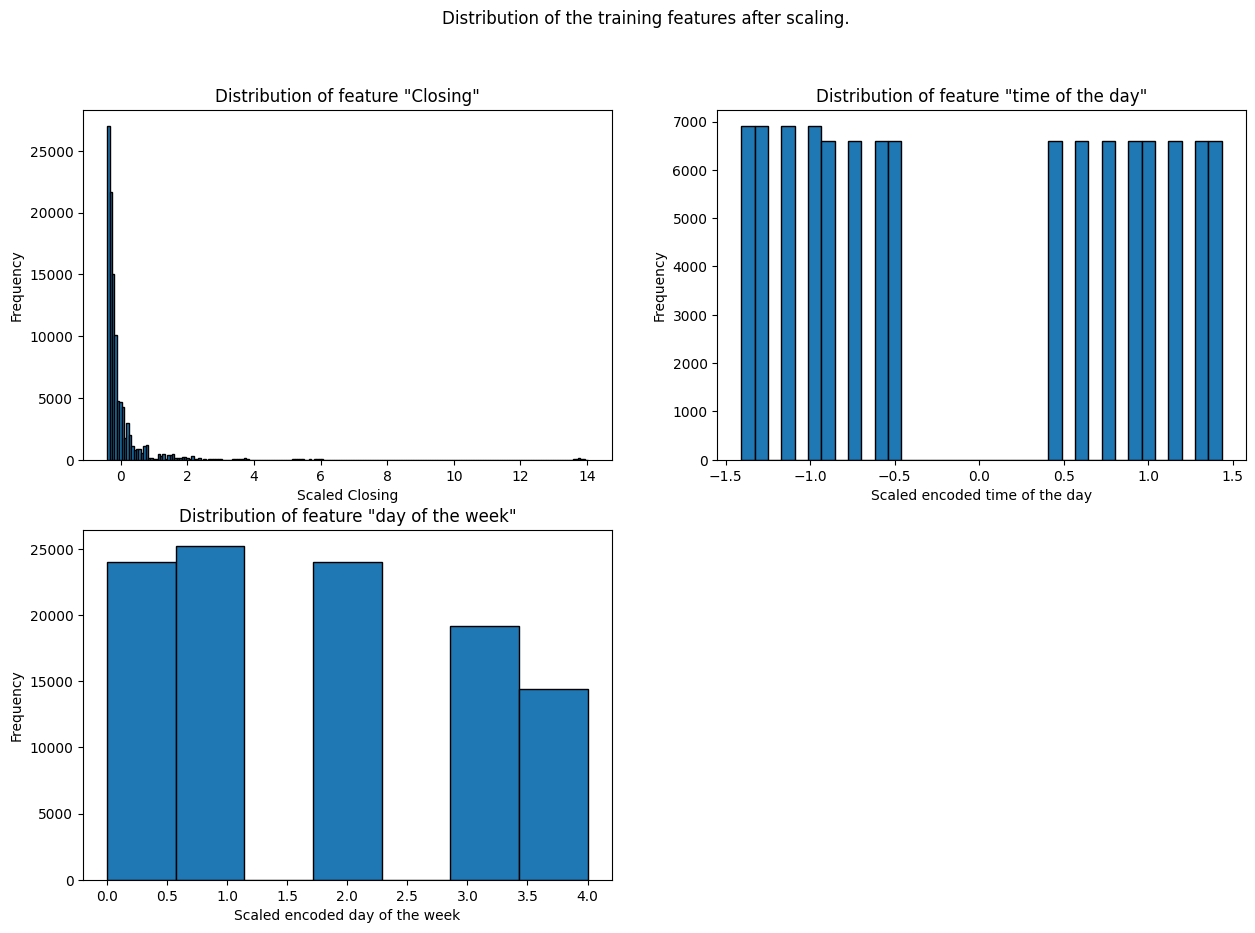

In [134]:
from src.data.data_analysis import plot_features_distribution

plot_features_distribution(
    statistics_df, bins=[200, 24 + 60 // 5, 7], 
    x_labels=['Scaled Closing', 'Scaled encoded time of the day',
              'Scaled encoded day of the week'],
    title='Distribution of the training features after scaling.')

接下来，对每个数据集应用大小为$(T_{in} + T_{out})$的滑动窗口，以获得其自监督版本，其中在每个窗口中：
* 前$T_{in}$个元素属于输入变量。
* 最后$T_{out}$个元素属于 ground truth（真实值）。

在实验中，$T_{in}$和$T_{out}$都设置为12。 


In [135]:
# 设置输入和输出时间步的数量。
N_IN_TIMESTEPS = 12
N_OUT_TIMESTEPS = 12

In [136]:
from src.data.data_processing import get_dataset_by_sliding_window

# 获取自监督训练的验证集和测试集。
x_train, y_train, x_train_time, y_train_time = get_dataset_by_sliding_window(
    train_dataset, train_times, x_stepsize=N_IN_TIMESTEPS,
    y_stepsize=N_OUT_TIMESTEPS)
x_val, y_val, x_val_time, y_val_time = get_dataset_by_sliding_window(
    val_dataset, val_times, x_stepsize=N_IN_TIMESTEPS,
    y_stepsize=N_OUT_TIMESTEPS)
x_test, y_test, x_test_time, y_test_time = get_dataset_by_sliding_window(
    test_dataset, test_times, x_stepsize=N_IN_TIMESTEPS,
    y_stepsize=N_OUT_TIMESTEPS)

In [137]:
print('Train dataset shapes:', x_train.shape, y_train.shape)
print('Validation dataset shapes:', x_val.shape, y_val.shape)
print('Test dataset shapes:', x_test.shape, y_test.shape)

Train dataset shapes: (14, 12, 300, 9) (14, 12, 300, 9)
Validation dataset shapes: (1, 12, 300, 9) (1, 12, 300, 9)
Test dataset shapes: (4, 12, 300, 9) (4, 12, 300, 9)


由于我们只对预测收盘价感兴趣，因此从真实数据中去除了时间编码特征。

因此，得到的数据集具有以下形状：
* $x \in \mathbb{R}^{T \times N \times (1 + F)}$
* $y \in \mathbb{R}^{T \times N \times 1}$

其中，$x$ 是输入数据，$y$ 是训练集、验证集或测试集的真实值。$T$ 对应于时间步长的数量，$N$ 对应于股票的数量，$F$ 表示代表时间步长编码的特征数量。 

In [138]:
# 从基本事实中移除时间编码特征。
y_train = y_train[..., :1]
y_val = y_val[..., :1]
y_test = y_test[..., :1]

In [139]:
print('Adjusted train dataset shapes:', x_train.shape, y_train.shape)
print('Adjusted validation dataset shapes:', x_val.shape, y_val.shape)
print('Adjusted test dataset shapes:', x_test.shape, y_test.shape)

Adjusted train dataset shapes: (14, 12, 300, 9) (14, 12, 300, 1)
Adjusted validation dataset shapes: (1, 12, 300, 9) (1, 12, 300, 1)
Adjusted test dataset shapes: (4, 12, 300, 9) (4, 12, 300, 1)


In [140]:
from numpy import save

# Save the processed datasets.
save(os.path.join(PROCESSED_DATA_DIR, 'x_train.npy'), x_train)
save(os.path.join(PROCESSED_DATA_DIR, 'y_train.npy'), y_train)
save(os.path.join(PROCESSED_DATA_DIR, 'x_val.npy'), x_val)
save(os.path.join(PROCESSED_DATA_DIR, 'y_val.npy'), y_val)
save(os.path.join(PROCESSED_DATA_DIR, 'x_test.npy'), x_test)
save(os.path.join(PROCESSED_DATA_DIR, 'y_test.npy'), y_test)

# Save the time information of the datasets.
save(os.path.join(PROCESSED_DATA_DIR, 'x_train_time.npy'), x_train_time)
save(os.path.join(PROCESSED_DATA_DIR, 'y_train_time.npy'), y_train_time)
save(os.path.join(PROCESSED_DATA_DIR, 'x_val_time.npy'), x_val_time)
save(os.path.join(PROCESSED_DATA_DIR, 'y_val_time.npy'), y_val_time)
save(os.path.join(PROCESSED_DATA_DIR, 'x_test_time.npy'), x_test_time)
save(os.path.join(PROCESSED_DATA_DIR, 'y_test_time.npy'), y_test_time)

# 2 模型定义与训练过程
在本节中，将定义模型并执行训练过程。

## 2.1 模型定义
创建了*时空图神经网络*模型。 

其目的是根据历史速度信息预测图中每个节点未来的交通速度。
具体而言，它根据图的前 $T_{in}$ 个连续历史表示，预测图的接下来 $T_{out}$ 个连续时间表示。

该模型架构包括：
* 一个编码器，从输入的图序列中提取隐藏特征。
* 一系列 *空间图神经网络（S-GNN）* 模块，通过结合特征信息对图的每个输入实例的空间结构进行建模，从而提取信息。此外，邻接矩阵也用于辅助此任务。
* 一系列*门控循环单元（GRU）*模块，用于提取输入图在连续时间步之间的时间关系信息。一个*GRU*模块的最终输出将作为下一个*GRU*模块的隐藏输入状态，并与图的下一个时间步一起进行处理。每个*GRU*模块的输出在传递给下一个*GRU*模块之前，会先通过一个*S-GNN*模块进行处理。
* 一个*Transformer*模块，执行*多头注意力*操作，以计算每个时间步之间的全局时间关系。*GRU*的输出被堆叠在一起，并与它们的*位置编码*连接。
* 一个*多层*回归头，用于推断输出 $T_{out}$ 序列的速度。
<center>

![](../images/stgnn.png)

</center>

In [141]:
from src.spatial_temporal_gnn.model import SpatialTemporalGNN

model = SpatialTemporalGNN(9, 1, N_IN_TIMESTEPS, N_OUT_TIMESTEPS, adj_matrix,
                           DEVICE, 64)

In [142]:
from torchinfo import summary

print(summary(model, input_size=(64, *x_train.shape[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
SpatialTemporalGNN                       [64, 12, 300, 1]          --
├─Linear: 1-1                            [64, 12, 300, 64]         576
├─ModuleList: 1-34                       --                        (recursive)
│    └─S_GNN: 2-1                        [64, 300, 64]             --
│    │    └─Sequential: 3-1              [64, 300, 32]             6,144
│    │    └─Linear: 3-2                  [64, 300, 64]             4,096
├─ModuleList: 1-36                       --                        (recursive)
│    └─GRU: 2-2                          [64, 300, 64]             --
│    │    └─Linear: 3-3                  [64, 300, 64]             4,096
│    │    └─Linear: 3-4                  [64, 300, 64]             4,096
│    │    └─Linear: 3-5                  [64, 300, 64]             4,096
│    │    └─Linear: 3-6                  [64, 300, 64]             4,096
│    │    └─Linear: 3-7                  [64, 30

## 2.2 训练流程
在本节中，将对模型进行训练。此外，还会构建训练集、验证集和测试集的数据加载器，并设置重要参数和训练工具。 

训练集、验证集和测试集的数据加载器已构建完成。仅对训练集数据加载器的数据进行打乱，目的是让模型减少过拟合，确保训练过程更具通用性。 

In [143]:
from src.data.dataloaders import get_dataloader

train_dataloader = get_dataloader(x_train, y_train, batch_size=64,
                                  shuffle=True)
val_dataloader = get_dataloader(x_val, y_val, batch_size=64,
                                shuffle=False)
test_dataloader = get_dataloader(x_test, y_test, batch_size=64,
                                 shuffle=False)

训练工具和参数已分配。
* 使用`Adam`作为优化器，学习率为$1e-3$，权重衰减为$2e-6$。
* 初始化一个检查点监视器，通过保存最佳结果权重来控制模型在验证集上的性能，最佳结果权重由最小误差组成，该最小误差计算为*平均绝对误差(MAE)*、*均方根误差(RMSE)*和*平均绝对百分比误差(MAPE)*之和。
* *epochs*设置训练轮数。

In [144]:
from src.spatial_temporal_gnn.training import Checkpoint

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-6)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=.1, patience=10, verbose=False,
    threshold=.001, threshold_mode='rel', cooldown=0, min_lr=1e-3, eps=1e-08)

checkpoint_file_path = os.path.join('..', 'models', 'checkpoints',
                                    'st_gnn_csi300.pth')
checkpoint = Checkpoint(checkpoint_file_path)

EPOCHS = 20

执行训练过程。损失准则是对未缩放的速度预测值和真实值计算的*平均绝对误差（MAE）*。

甚至还跟踪相对于训练和验证预测性能的*均方根误差（RMSE）*和*平均绝对百分比误差（MAPE）*。

模型在缩放后的数据上进行训练，并在未缩放的数据上进行评估。做出此决定的原因在于，在这种情况下模型性能有所提升。此外，在未缩放的数据上计算损失函数，意味着更严格的误差惩罚，并且与原始实验结果的对比也更为真实。 

In [145]:
from src.spatial_temporal_gnn.training import train

history = train(model, optimizer, train_dataloader, val_dataloader, scaler,
                EPOCHS, DEVICE, checkpoint=checkpoint, 
                lr_scheduler=lr_scheduler, reload_best_weights=True)

Epoch 1/20
[1/1] - 1s - train: { MAE (loss): 53.5 - RMSE: 112 - MAPE: 357% } - val: { MAE: 48.6 - RMSE: 113 - MAPE: 287% } - lr: 0.001 - weight decay: 2e-06
Epoch 2/20
[1/1] - 1s - train: { MAE (loss): 48.3 - RMSE: 111 - MAPE: 293% } - val: { MAE: 44.8 - RMSE: 113 - MAPE: 233% } - lr: 0.001 - weight decay: 2e-06
Epoch 3/20
[1/1] - 1s - train: { MAE (loss): 44.2 - RMSE: 111 - MAPE: 238% } - val: { MAE: 42 - RMSE: 113 - MAPE: 187% } - lr: 0.001 - weight decay: 2e-06
Epoch 4/20
[1/1] - 1s - train: { MAE (loss): 41.3 - RMSE: 110 - MAPE: 191% } - val: { MAE: 39.9 - RMSE: 113 - MAPE: 149% } - lr: 0.001 - weight decay: 2e-06
Epoch 5/20
[1/1] - 1s - train: { MAE (loss): 39.1 - RMSE: 110 - MAPE: 153% } - val: { MAE: 38.2 - RMSE: 113 - MAPE: 119% } - lr: 0.001 - weight decay: 2e-06
Epoch 6/20
[1/1] - 1s - train: { MAE (loss): 37.4 - RMSE: 110 - MAPE: 122% } - val: { MAE: 37 - RMSE: 113 - MAPE: 97.2% } - lr: 0.001 - weight decay: 2e-06
Epoch 7/20
[1/1] - 1s - train: { MAE (loss): 36.2 - RMSE: 110

In [146]:
from torch.utils.data import DataLoader
from typing import Tuple
import numpy as np

def predict(
    model: SpatialTemporalGNN, dataloader: DataLoader, scaler: Scaler, device: str
) -> Tuple[np.ndarray, np.ndarray]:
    """返回真实值（y_true）和模型预测值（y_pred）"""
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.type(torch.float32).to(device)
            y = y.type(torch.float32).to(device)
            # 缩放输入并预测
            x_scaled = scaler.scale(x)
            y_pred = model(x_scaled)
            y_pred = scaler.un_scale(y_pred)
            # 转换为CPU和NumPy
            y_true_list.append(y.cpu().numpy())
            y_pred_list.append(y_pred.cpu().numpy())
    # 合并批次数据
    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)
    return y_true, y_pred

In [147]:
# 假设使用验证集进行预测
y_true, y_pred = predict(model, val_dataloader, scaler, DEVICE)

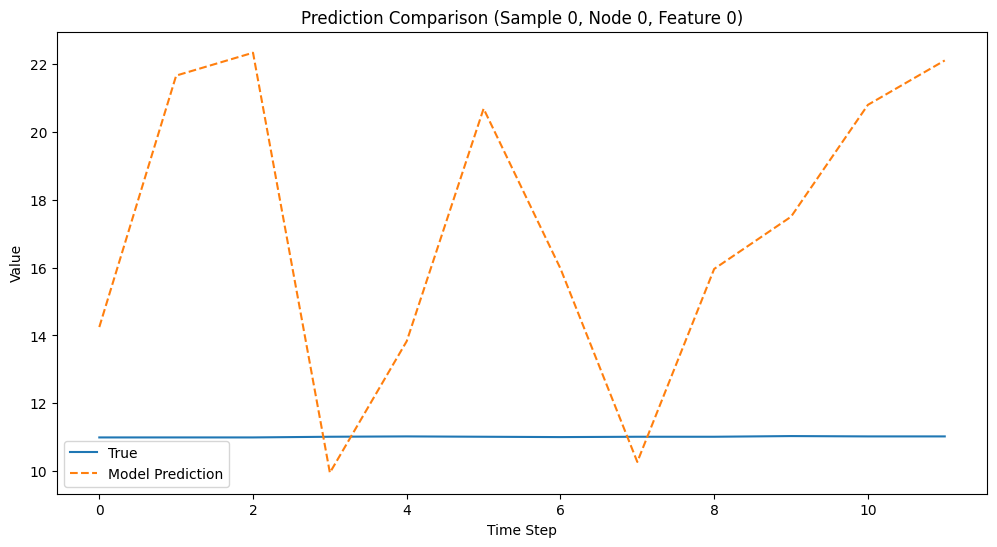

In [148]:
import matplotlib.pyplot as plt
def plot_predictions(true_data: np.ndarray, pred_data: np.ndarray, sample_idx: int = 0, node: int = 0, feature: int = 0):
    """绘制某个样本、节点和特征的预测对比"""
    plt.figure(figsize=(12, 6))
    plt.plot(true_data[sample_idx, :, node, feature], label="True")
    plt.plot(pred_data[sample_idx, :, node, feature], label="Model Prediction", linestyle="--")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Prediction Comparison (Sample {sample_idx}, Node {node}, Feature {feature})")
    plt.legend()
    plt.show()

# 示例：绘制第一个样本、第一个节点、第一个特征的对比
plot_predictions(y_true, y_pred, sample_idx=0, node=0, feature=0)

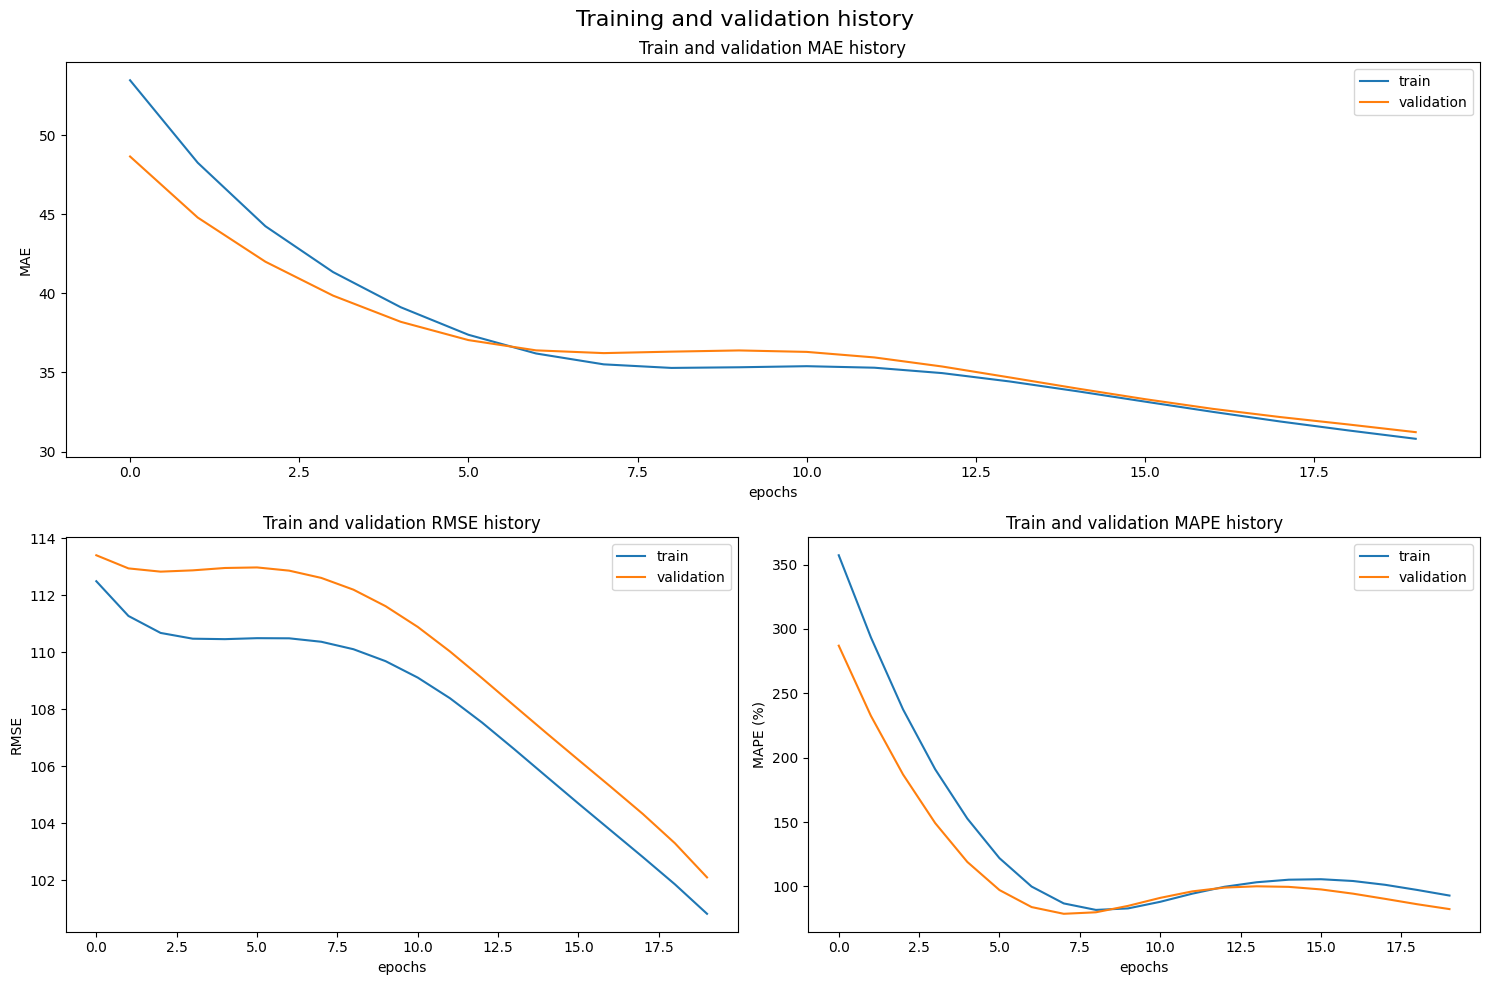

In [149]:
from src.spatial_temporal_gnn.training import plot_training_history

plot_training_history(history)

# 3 评估与误差分析
最终在测试数据集上对模型进行评估，并进行简要的误差分析。

在测试数据集上对训练好的模型进行评估，同时考虑未来15分钟、30分钟和60分钟预测的误差结果。

正如预期的那样，从时间上看，对更近发生事件的预测导致的误差更低。

In [150]:
from src.spatial_temporal_gnn.training import validate

test_mae_15_min, test_rmse_15_min, test_mape_15_min = validate(
    model, test_dataloader, scaler,
    DEVICE, 3)
print('Results on the test set considering the next 15 minutes:',
      f'MAE {test_mae_15_min:.3g} - RMSE {test_rmse_15_min:.3g}',
      f'- MAPE {test_mape_15_min * 100.:.3g} %')

test_mae_30_min, test_rmse_30_min, test_mape_30_min = validate(
    model, test_dataloader, scaler,
    DEVICE, 6)
print('Results on the test set considering the next 30 minutes:',
      f'MAE {test_mae_30_min:.3g} - RMSE {test_rmse_30_min:.3g}',
      f'- MAPE {test_mape_30_min * 100.:.3g} %')

test_mae_60_min, test_rmse_60_min, test_mape_60_min = validate(
    model, test_dataloader, scaler,
    DEVICE)
print('Results on the test set considering the next 60 minutes:',
      f'MAE {test_mae_60_min:.3g} - RMSE {test_rmse_60_min:.3g}',
      f'- MAPE {test_mape_60_min * 100.:.3g} %')

Results on the test set considering the next 15 minutes: MAE 32 - RMSE 105 - MAPE 99.6 %
Results on the test set considering the next 30 minutes: MAE 31.3 - RMSE 104 - MAPE 88.2 %
Results on the test set considering the next 60 minutes: MAE 31.1 - RMSE 103 - MAPE 87.9 %


In [151]:
from src.spatial_temporal_gnn.prediction import (
    get_ground_truth_and_predictions)

y_true, y_pred = get_ground_truth_and_predictions(
    model, test_dataloader, DEVICE, scaler, use_standardized_scale=False)

下一幅图展示了在测试数据集中，针对一系列随机选择的节点和时间戳，实际速度与预测速度的对比情况。我们可以看到，该模型表现相当不错，尽管一些速度峰值和谷值很难被准确预测。 

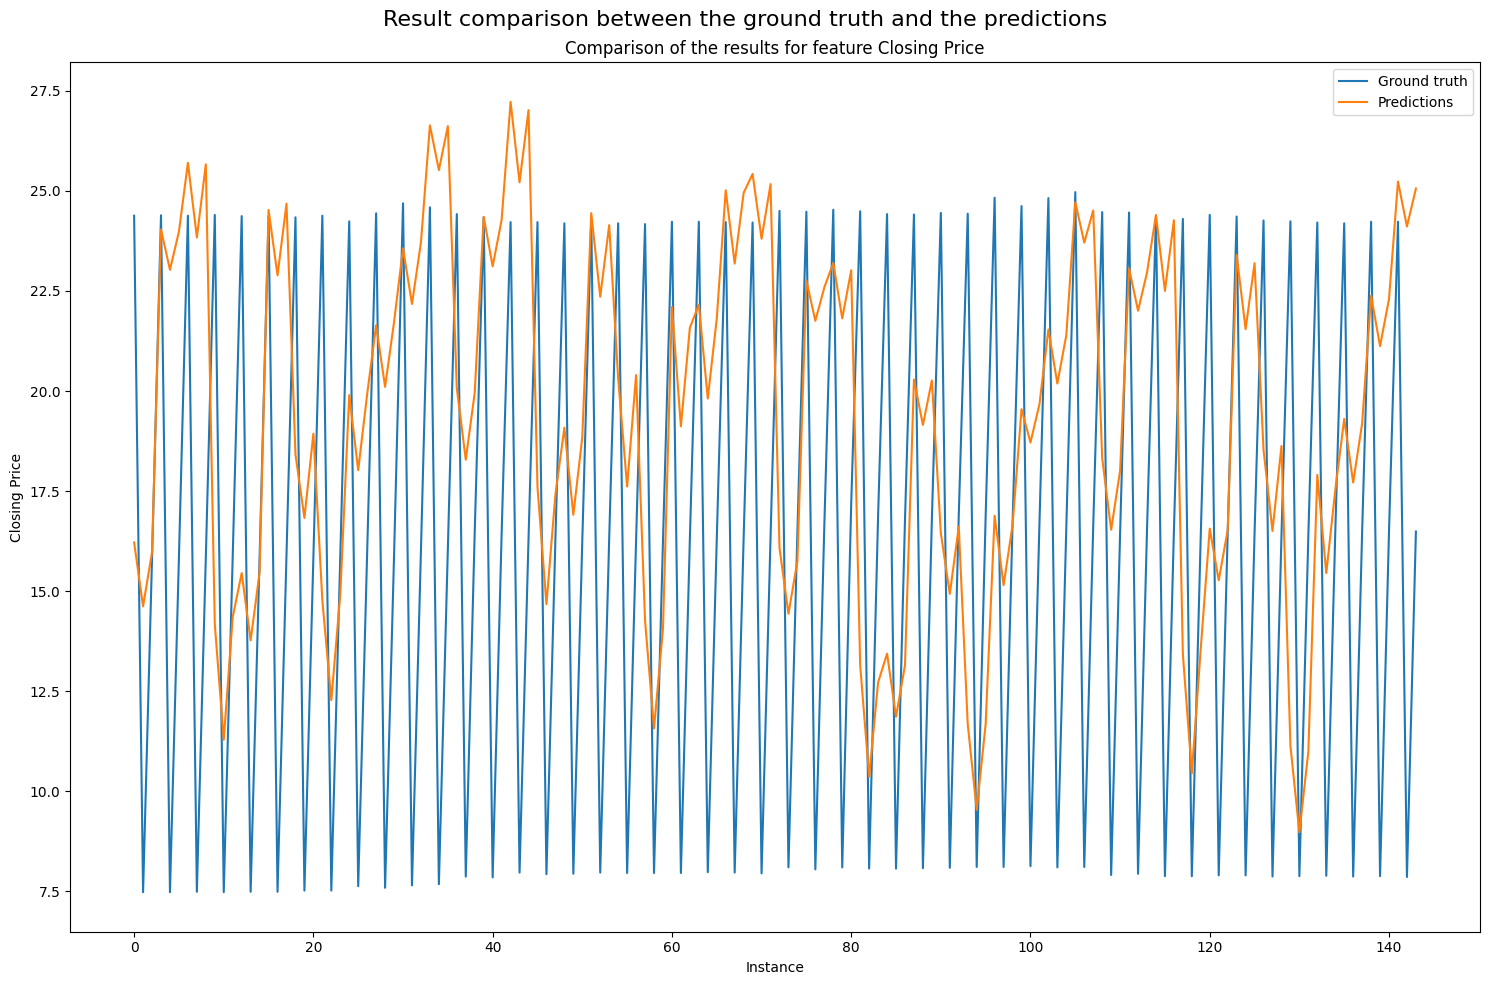

In [152]:
from src.spatial_temporal_gnn.prediction import plot_results_comparison

# 获取实际数据量
n_samples = y_true.shape[0]  # 总样本数
n_nodes = y_true.shape[2]    # 节点数量

# 动态设置抽样数量（不超过实际容量）
plot_results_comparison(
    y_true, 
    y_pred, 
    ['Closing Price'],
    n_random_instances=min(100, n_samples),
    n_random_nodes=min(3, n_nodes)
)

最后，我们观察到该散点图展示了在测试数据集中，一系列随机选择的节点和时间戳下，实际速度与预测速度的契合度。

看起来，高速节点的误差变化比低速节点的误差变化更大。这是意料之中的，因为数据集中速度的分布明显左偏。 

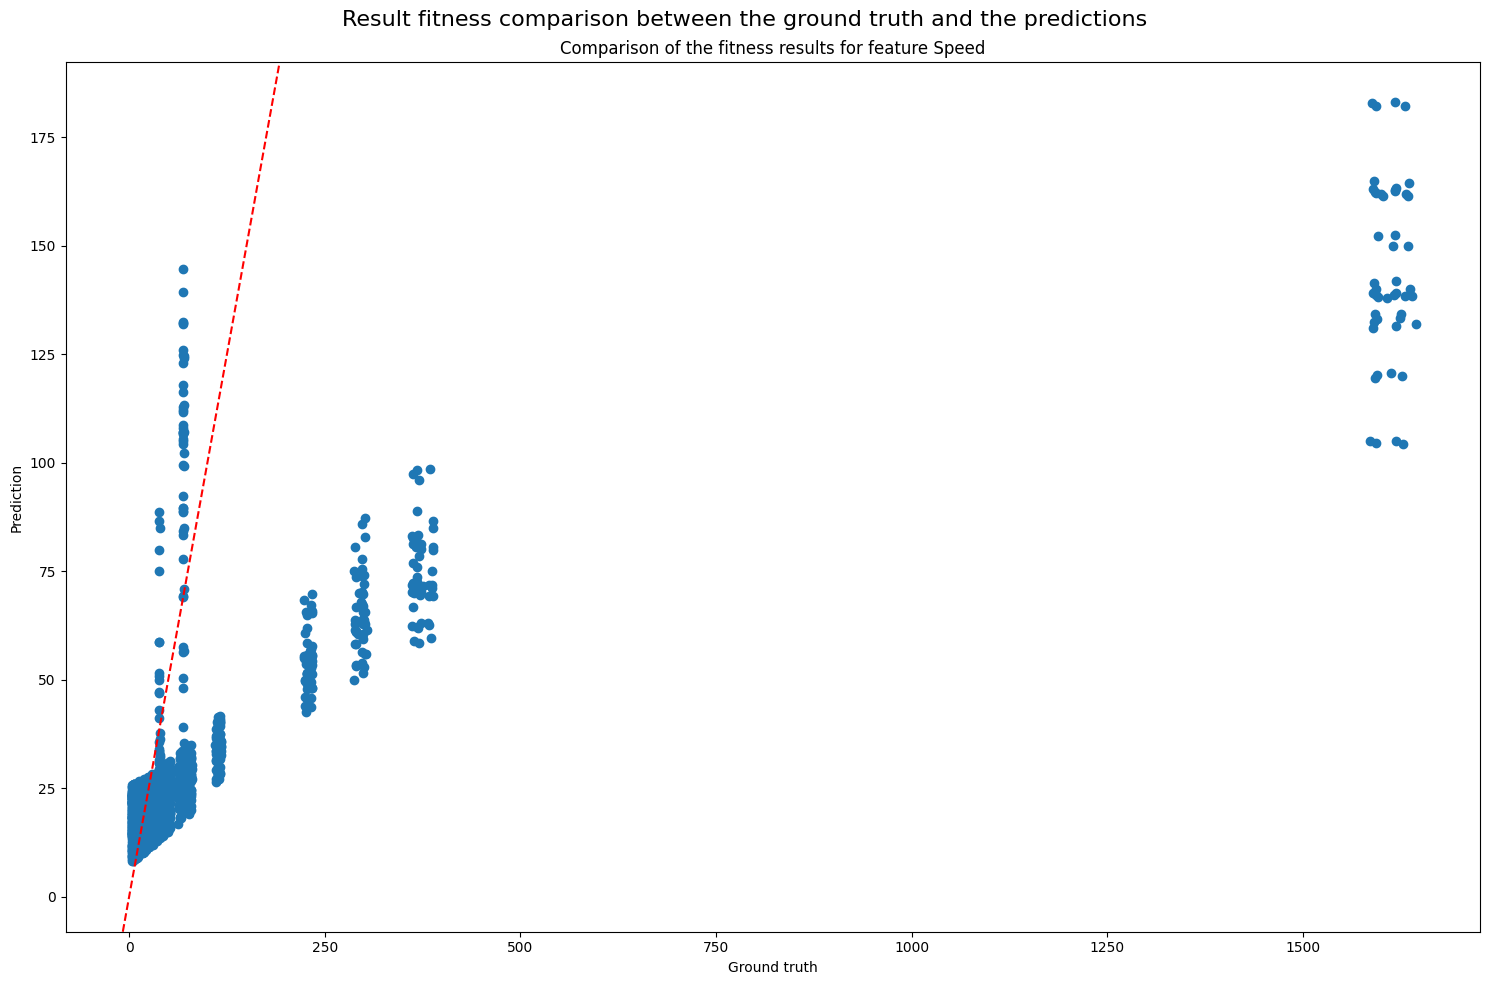

In [153]:
from src.spatial_temporal_gnn.prediction import plot_results_fitness

plot_results_fitness(y_true, y_pred, ['Speed'])

包含输入及其预测结果的数据集最终生成并保存，以供未来在可解释性过程中使用。

In [154]:
import os
import numpy as np
from src.spatial_temporal_gnn.prediction import predict

PREDICTED_DATA_DIR = os.path.join('..', 'data', 'csi300', 'predicted')

os.makedirs(PREDICTED_DATA_DIR, exist_ok=True)

# Save the predicted data.
np.save(os.path.join(PREDICTED_DATA_DIR, 'x_train.npy'), x_train)
y_train = predict(model, x_train, scaler, DEVICE)
np.save(os.path.join(PREDICTED_DATA_DIR, 'y_train.npy'), y_train)
np.save(os.path.join(PREDICTED_DATA_DIR, 'x_val.npy'), x_val)
y_val = predict(model, x_val, scaler, DEVICE)
np.save(os.path.join(PREDICTED_DATA_DIR, 'y_val.npy'), y_val)
np.save(os.path.join(PREDICTED_DATA_DIR, 'x_test.npy'), x_test)
y_test = predict(model, x_test, scaler, DEVICE)
np.save(os.path.join(PREDICTED_DATA_DIR, 'y_test.npy'), y_test)

# Save the predicted time information of the datasets.
np.save(os.path.join(PREDICTED_DATA_DIR, 'x_train_time.npy'), x_train_time)
np.save(os.path.join(PREDICTED_DATA_DIR, 'y_train_time.npy'), y_train_time)
np.save(os.path.join(PREDICTED_DATA_DIR, 'x_val_time.npy'), x_val_time)
np.save(os.path.join(PREDICTED_DATA_DIR, 'y_val_time.npy'), y_val_time)
np.save(os.path.join(PREDICTED_DATA_DIR, 'x_test_time.npy'), x_test_time)
np.save(os.path.join(PREDICTED_DATA_DIR, 'y_test_time.npy'), y_test_time)